In questo programma viene eseguita anomaly detection su un dataset di consumi elettrici riguardanti un'ufficio italiano; nello specifico le anomalie vengono identificate nei giorni in cui i consumi sono significativamente diversi dal trend usuale.
Il modello predittivo utilizzato in questo caso è una combinazione di 10 reti neurali MLP, aventi medesima struttura, le quali vengo allenate con insiemi di dati leggermente diversi tra di loro. Successivamente, al momento della predizione, i risultati delle singole reti vengono combinati insieme usando un metodo di ensembling portando in output del modello la predizione definitiva. 

Come input per il modello predittivo si prende il campionamento dei consumi elettrici eseguito ogni 2 ore per un'intera settimana (7 giorni consecutivi) mentre come output si hanno i consumi, campionati ogni 2 ore anch'essi, della giornata successiva alla settimana presa in input. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import holidays
import datetime
import sklearn
from sklearn import neural_network
from sklearn import model_selection
import random
# %matplotlib notebook

In [4]:
data = pd.read_pickle('train1.pkl')
data = data.drop(data.columns[[0,4]], axis=1)
en = []
for i in range(len(data)):
    en.append(i)
data['indice'] = en
data.set_index('indice', inplace = True)
data

,AvgT,AvgH,AvgP2,DateTime,holidays,dayofweek
indice,,,,,,
0,4.30,94.199997,34.0,2017-02-08 00:00:00,0,2
1,4.80,94.550003,0.0,2017-02-08 00:15:00,0,2
2,5.40,94.800003,51.0,2017-02-08 00:30:00,0,2
3,5.40,94.449997,0.0,2017-02-08 00:45:00,0,2
4,5.50,94.199997,0.0,2017-02-08 01:00:00,0,2
...,...,...,...,...,...,...
75931,10.95,83.250000,41.0,2019-04-09 22:45:00,0,1
75932,10.80,84.599998,42.0,2019-04-09 23:00:00,0,1
75933,10.65,86.050003,43.0,2019-04-09 23:15:00,0,1


Viene eseguita della pulizia dei dati, rimuovendo le prime giornate registrate a causa di un campionamento incompleto e rimuovendo i dati duplicati nel caso ci siano più di un valore a una determinata data e a un determinato orario. 

In [5]:
toremove = []

for ind, sample in data.iterrows():
    if sample['DateTime'] < datetime.datetime(2017, 2, 8): 
        toremove.append(ind)
    elif sample['AvgP2'] == 0:
        toremove.append(ind)
        
data.drop(toremove, inplace = True)
data.sort_index(inplace = True)
data.drop_duplicates(subset = 'DateTime', keep = 'first', inplace = True)

Avviene ora una scomposizione del dato Data-Ora in più attributi. Dal momento che l'obiettivo è avere un campionamento con frequenza di 1 campione ogni 2 ore, il valore rappresentante l'ora della giornata viene diviso per 2 trascurando il possibile resto prodotto (divisione naturale).

In [6]:
dat = {'Power':[], 'Year':[], 'Month':[], 'Day':[], 
       'Hour':[], 'Minutes':[], 'holidays':[], 'dayofweek':[]}

for ind, sample in data.iterrows():
    dat['Year'].append(sample['DateTime'].year)
    dat['Month'].append(sample['DateTime'].month)
    dat['Day'].append(sample['DateTime'].day)
    dat['Hour'].append(sample['DateTime'].hour//2)
    dat['Minutes'].append(sample['DateTime'].minute)
    dat['Power'].append(sample['AvgP2'])
    dat['holidays'].append(sample['holidays'])
    dat['dayofweek'].append(sample['dayofweek'])

In [7]:
data = pd.DataFrame.from_dict(dat)
data

,Power,Year,Month,Day,Hour,Minutes,holidays,dayofweek
0,34.0,2017,2,8,0,0,0,2
1,51.0,2017,2,8,0,30,0,2
2,52.0,2017,2,8,0,45,0,2
3,42.0,2017,2,8,1,15,0,2
4,51.0,2017,2,8,1,0,0,2
...,...,...,...,...,...,...,...,...
75518,41.0,2019,4,9,11,45,0,1
75519,42.0,2019,4,9,11,0,0,1
75520,43.0,2019,4,9,11,15,0,1
75521,42.0,2019,4,9,11,30,0,1


Avviene una riduzione del volume dei dati: 1 record ogni 2 ore. Vengono inoltre eliminate le colonne relative ai minuti, giorno della settimana e vacanze.

In [8]:
data.drop(['Minutes', 'holidays', 'dayofweek'], axis = 1, inplace = True)
data = data.groupby(['Year', 'Month', 'Day', 'Hour']).mean().reset_index()
data

,Year,Month,Day,Hour,Power
0,2017,2,8,0,45.666667
1,2017,2,8,1,46.500000
2,2017,2,8,2,53.500000
3,2017,2,8,3,57.000000
4,2017,2,8,4,89.000000
...,...,...,...,...,...
9453,2019,4,9,7,81.625000
9454,2019,4,9,8,64.875000
9455,2019,4,9,9,60.875000
9456,2019,4,9,10,46.500000


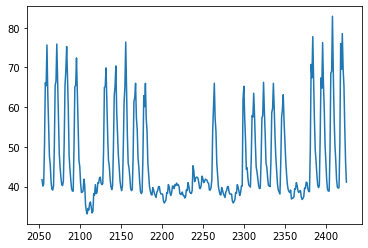

In [9]:
#mese di test: agosto 2017
d = data.loc[(data['Month'] == 8) & (data['Year'] == 2017)]
plt.plot(d['Power'])
plt.show()

Come train set vengono presi i dati relativi ai mesi di luglio, settembre e ottobre 2017 data la loro omegeneità a livello di valori dei consumi e per l'assenza di giornate anomale. Dopo un'analisi del dataset nel suo complesso si è infatti notato che, seppur i trend rimangono costanti, i valori effettivi dei consumi variano significativamente tra diverse stagioni. Questo porta a una maggiore difficoltà da parte del modello nel compiere predizioni corrette. Di conseguenza, per questa sperimentazione si è voluto trattare solo dati inerenti alla stagionalità estiva.

In [10]:
train = []
train.append(data.loc[(data['Month'] == 7) & (data['Year'] == 2017)]['Power'])
train.append(data.loc[((data['Month'] == 9) | (data['Month'] == 10)) & (data['Year'] == 2017)]['Power'])

Come test set vengono prese le giornate relative alla prima metà di agosto 2017 (le giornate per cui si andrà a fare la predizione saranno dal 8 al 14 agosto). Tra queste è presente una anomalia: il 14 agosto è infatti un lunedì con consumi molto bassi rispetto al trend usuale.

In [11]:
test = data.loc[(data['Month'] == 8) & (data['Year'] == 2017)].reset_index()
test = test.drop(test.loc[test['Day'] > 14].index)

In questa fase viene effettivamente creato il train set (dataset usato per allenare il modello predittivo). I valori relativi ai consumi registrati vengono normalizzati su una distribuzione uniforme nel range [0, 1]. Sul dataset prodotto la distanza temporale tra un dato e il successivo è di 1 giorno (12 valori sul dataset inziale).

In [12]:
max_power = 0
min_power = 100000
for serie in train:
    max_power = max(max_power, max(serie))
    min_power = min(min_power, min(serie))
max_power = max(max_power, max(test['Power'])) 
min_power = min(min_power, min(test['Power']))

delta_power = max_power - min_power
norm_x = []

norm_x.append([])
for record in train[0]:
    norm_x[-1].append((record-min_power)/delta_power)  
norm_x.append([])
for record in train[1]:
    norm_x[-1].append((record-min_power)/delta_power)
    
temp = []
y = []
for h in range(len(norm_x)):
    ind = 0
    while ind <= len(norm_x[h])-12*8:
        new_row = []
        for i in range(12*7):
            new_row.append(norm_x[h][i+ind])
        temp.append(new_row)    
        new_row = []    
        for i in range(12):
            new_row.append(norm_x[h][ind+i+12*7])
        y.append(new_row)
        ind += 12   
        
X_train = pd.DataFrame(temp)
y_train = pd.DataFrame(y)
X_train

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.138158,0.131579,0.144737,0.186404,0.201754,0.201754,0.138158,0.122807,0.157895,0.171053,...,0.125000,0.311404,0.640351,0.679825,0.760965,0.679825,0.412281,0.269737,0.208333,0.182018
1,0.151316,0.140351,0.142544,0.125000,0.118421,0.100877,0.100877,0.100877,0.149123,0.151316,...,0.140351,0.206140,0.263158,0.252193,0.116228,0.114035,0.144737,0.140351,0.168860,0.182018
2,0.149123,0.138158,0.146930,0.315789,0.646930,0.675439,0.831140,0.703947,0.484649,0.274123,...,0.127193,0.118421,0.098684,0.087719,0.087719,0.103070,0.144737,0.155702,0.182018,0.171053
3,0.151316,0.144737,0.144737,0.342105,0.644737,0.695175,0.822368,0.739035,0.515351,0.315789,...,0.133772,0.344298,0.690789,0.686404,0.800439,0.697368,0.486842,0.432957,0.179825,0.635965
4,0.135965,0.127193,0.122807,0.335526,0.662281,0.728070,0.844298,0.712719,0.515351,0.359649,...,0.692982,0.548246,0.396930,0.206140,0.177632,0.146930,0.140351,0.140351,0.320175,0.657895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0.059211,0.043860,0.048246,0.219298,0.760965,0.778509,0.914474,0.741228,0.524123,0.388158,...,0.061404,0.236842,0.699561,0.690789,0.817982,0.725877,0.592105,0.390351,0.206140,0.109649
73,0.072368,0.057018,0.054825,0.118421,0.276316,0.217105,0.230263,0.182018,0.105263,0.107456,...,0.074561,0.298246,0.842105,0.708333,0.831140,0.760965,0.605263,0.346491,0.199561,0.100877
74,0.065789,0.048246,0.041667,0.046053,0.035088,0.015351,0.015351,0.030702,0.070175,0.087719,...,0.072368,0.223684,0.265351,0.239035,0.103070,0.061404,0.107456,0.129386,0.129386,0.114035
75,0.043860,0.041667,0.041667,0.221491,0.657895,0.616228,0.857456,0.774123,0.576754,0.379386,...,0.072368,0.074561,0.059211,0.052632,0.070175,0.065789,0.129386,0.138158,0.129386,0.105263


Si procede ora con l'allenamento dei 10 modelli MLP. Essi vengono allenati con insiemi di dati leggermente diversi gli uni dagli altri (altrimenti avrebbero tutti il medesimo comportamento). Nello specifico il volume di dati che effettivamente viene usato per allenare i singoli modelli è pari al 80% del train set iniziale. 
Tutte le reti neurali utilizzate sono composte al loro interno da 3 layer composti a loro volta da 40 neuroni ognuno, la funzione di attivazione utilizzata su questi neuroni è la tangente iperbolica e il valore massimo di iterazioni eseguibili è impostato a 1000.

In [13]:
in_line = []
for i in X_train.index.values:
    in_line.append(i)
regressors = []
for i in range(10):
    random.shuffle(in_line)
    Xi_train = []
    yi_train = []
    for line in range(int(len(in_line)*0.8)):
        Xi_train.append(X_train.loc[in_line[line]])
        yi_train.append(y_train.loc[in_line[line]])
    model = neural_network.MLPRegressor(hidden_layer_sizes = (40, 40, 40), activation = 'tanh', max_iter = 1000).fit(Xi_train, yi_train)
    regressors.append(model)

Il medesimo procedimento per la composizione del train set viene eseguito per la realizzazione del test set, anch'esso normalizzando i dati come fatto in precedenza.

In [14]:
X_test = []
y_test = []

ind = 0
while ind<=len(test.index)-8*12:
    new_row = []
    for i in range(ind, ind+7*12):
        new_row.append((test.iloc[i]['Power']-min_power)/delta_power)
    X_test.append(new_row)
    new_row = []
    for i in range(ind+7*12, ind+8*12):
        new_row.append((test.iloc[i]['Power']-min_power)/delta_power)
    y_test.append(new_row)
    ind += 12
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)
y_test

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.144737,0.131579,0.149123,0.315789,0.546053,0.587719,0.677632,0.475877,0.381579,0.285088,0.232456,0.171053
1,0.142544,0.127193,0.146930,0.309211,0.515351,0.585526,0.782895,0.574561,0.372807,0.247807,0.228070,0.186404
2,0.135965,0.127193,0.131579,0.271930,0.521930,0.537281,0.600877,0.449561,0.396930,0.271930,0.230263,0.166667
3,0.122807,0.114035,0.120614,0.280702,0.546053,0.497807,0.600877,0.445175,0.388158,0.247807,0.192982,0.144737
4,0.125000,0.109649,0.107456,0.140351,0.129386,0.114035,0.105263,0.096491,0.120614,0.127193,0.144737,0.144737
5,0.120614,0.111842,0.111842,0.111842,0.081140,0.072368,0.078947,0.085526,0.118421,0.116228,0.153509,0.142544
6,0.116228,0.105263,0.118421,0.146930,0.146930,0.135965,0.153509,0.149123,0.160088,0.151316,0.153509,0.144737


Ora si vanno a registrare i valori predetti dai modelli allenati in precedenza sui dati del test set. Essi sono ottenuti eseguendo una tecnica di ensembling (in questo caso si utilizza la media aritmetica) tra i vari risultati riguardanti il medesimo input.

In [15]:
predicted = []
for i in range(10):
    prediction = regressors[i].predict(X_test)
    predicted.append(prediction)
predicted_mean = []
for i in range(len(y_test)):
    prediction = []
    for j in range(12):
        prediction.append(0)
    for j in range(10):
        for h in range(12):
            prediction[h] += predicted[j][i][h]/10
    predicted_mean.append(prediction)
predicted = pd.DataFrame(predicted_mean)  
predicted

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.182422,0.234160,0.173139,0.303000,0.600927,0.550567,0.673175,0.604167,0.473809,0.332476,0.202494,0.217900
1,0.180022,0.231071,0.193297,0.277267,0.583106,0.572676,0.662913,0.609792,0.485082,0.342937,0.216329,0.227211
2,0.194596,0.230927,0.152408,0.301193,0.666411,0.616966,0.769764,0.677314,0.532030,0.358824,0.218179,0.191006
3,0.195068,0.220847,0.160173,0.285547,0.582851,0.511681,0.565329,0.517583,0.394158,0.284155,0.188525,0.154027
4,0.142291,0.142148,0.131399,0.147781,0.218736,0.167708,0.123701,0.103614,0.106067,0.152704,0.136082,0.136697
5,0.137355,0.152042,0.130487,0.152629,0.207205,0.157240,0.179283,0.160266,0.153680,0.168145,0.173510,0.202263
6,0.162384,0.206736,0.161719,0.264030,0.537163,0.483632,0.593541,0.509833,0.427473,0.323216,0.200522,0.234789


Di seguito vengono stampati i risultati ottenuti sul test set mettendo a confronto i valori predetti con i valori reali.

8


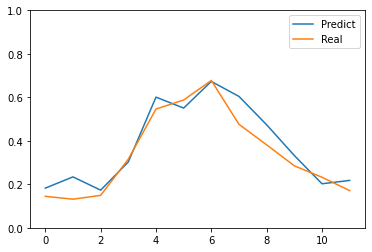

9


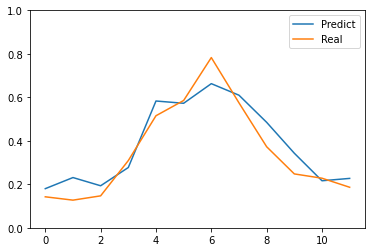

10


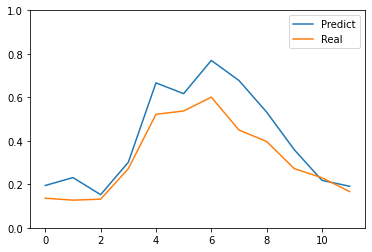

11


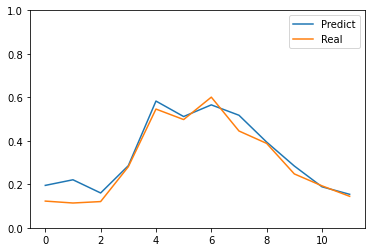

12


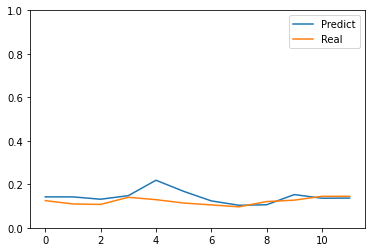

13


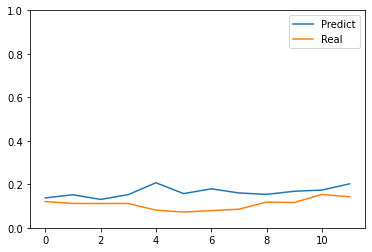

14


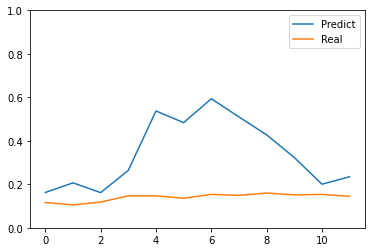

In [16]:
for i, sample in predicted.iterrows():
    print(i+7+1)
    plt.plot(predicted.columns, predicted.loc[i], label='Predict')
    plt.plot(y_test.columns, y_test.loc[i], label='Real')
    plt.ylim((0,1))
    plt.legend()
    plt.show()